<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 9 -  Convoluções
**Nome: Augusto Cesar de Camargo Neto**

**Numero Usp: 11891023**









______________




O objetivo desta lista é fazer com que vocês se familiarizem com redes convolucionais, vocês ja tiveram um contato breve com essa arquitetura algumas listas atrás mas dessa vez vocês cuidarão sozinhos da implementação e deverão tomar medidas para evitar overfitting. Novamente, as questões 1 2 e 3 podem ser copiadas de listas anteriores.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from unidecode import unidecode
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout, Input, Embedding

In [2]:
tf.__version__

'2.2.1'

### Importando os dados como um dataframe

Para esta lista nós utilizaremos o dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [3]:
b2wCorpus = pd.read_csv("../Semana 03/data/B2W-Reviews01.csv",";",usecols=['review_text','recommend_to_a_friend'], encoding='utf-8')
for i, row in b2wCorpus.iterrows():
    ifor_val = unidecode(row['review_text']).lower()
    b2wCorpus.at[i,'review_text']= ifor_val
b2wCorpus.head()

,recommend_to_a_friend,review_text
0,Yes,estou contente com a compra entrega rapida o u...
1,Yes,"por apenas r$1994.20,eu consegui comprar esse ..."
2,Yes,supera em agilidade e praticidade outras panel...
3,Yes,meu filho amou! parece de verdade com tantos d...
4,Yes,"a entrega foi no prazo, as americanas estao de..."


In [4]:
b2wCorpus["review_text"]

0         estou contente com a compra entrega rapida o u...
1         por apenas r$1994.20,eu consegui comprar esse ...
2         supera em agilidade e praticidade outras panel...
3         meu filho amou! parece de verdade com tantos d...
4         a entrega foi no prazo, as americanas estao de...
                                ...                        
132368    vale muito, estou usando no controle do xbox e...
132369    pratico e barato, super indico o produto para ...
132370    chegou antes do prazo previsto e corresponde a...
132371    material fraco, poderia ser melhor. ficou deve...
132372    comprei esse produto, quando chegou estava com...
Name: review_text, Length: 132373, dtype: object


### Pré-processamento
Seria util nos livrarmos das colunas que não são relevantes para o nosso problema e tambem verificar se não tem nada de esquisito nas colunas que vamos utilizar. 
Por exemplo, se fossemos utilizar a coluna "reviewer_gender" nós precisariamos nos livrar desses valores esquisitos:

In [5]:
#b2wCorpus["reviewer_gender"].value_counts()

## <font color='blue'>Questão 1 </font>

a) Selecione apenas as colunas relevantes: "review_text" e "recommend_to_a_friend". 

b) Converta a coluna "recommend_to_a_friend" de uma coluna de `str` para uma coluna de `int`:

- "Yes"-> 1
- "No" -> 0


In [6]:
b2wCorpus['recommend_to_a_friend'] = b2wCorpus['recommend_to_a_friend'].apply(lambda word : 1 if str(word).lower() == 'yes' else 0)
b2wCorpus.head()
b2wCorpus["recommend_to_a_friend"].value_counts()

1    96368
0    36005
Name: recommend_to_a_friend, dtype: int64

In [7]:
SEQUENCE_MAXLEN = 50


### Separando em teste e treino
## <font color='blue'>Questão 2 </font>

Agora com o dataset já pré-processado, separe o em 2 partes, um conjunto de teste e um conjunto de treino. Novamente você pode utilizar a função [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do Scikit-Learn como na lista passada.

In [8]:
RANDOM_SEED = 42
b2wCorpus.dropna(how='all')
x = b2wCorpus['review_text'].values.astype('str')
b2wCorpus['recommend_to_a_friend'] = b2wCorpus[['recommend_to_a_friend']].values.astype('int')
y = b2wCorpus['recommend_to_a_friend'].values.astype('int')
np.random.seed(RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)
b2wCorpus['recommend_to_a_friend'].value_counts()


1    96368
0    36005
Name: recommend_to_a_friend, dtype: int64

### Tokenizando

Para alimentarmos os reviews a camada de embedding nós precisamos quebrar cada review em uma serie de tokens. Existem diversas maneiras de se realizar isso e poderiamos até mesmo usar outras bibliotecas como o spaCy. 

Por exemplo, o objeto [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) oferece um método `tokenize` para quebrar as palavras em tokens individuais ao mesmo tempo que filtra caracteres indesejados (por default os caracteres filtrados são: !"#$\%&()*+,-./:;<=>?@[\\]^_\`{|}~\t\n).


Para essa lista utilizaremos a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) para automaticamente passar os reviews para caixa-baixa, extrair caracteres especiais e tokenizar as palavras de maneira a serem passadas para a camada de embedding. Ao tornarmos a etapa de tokenização uma camada de rede neural nós podemos incluir esse processamento dos reviews no proprio modelo.


## <font color='blue'>Questão 3 </font>
Utilizando a camada `TextVectorization` tokenize os inputs.
Declare a camada e então chame a função `adapt()` para adequar o seu vocabulário aos reviews.

Não se esqueça de se certificar que todas os reviews tenham o mesmo comprimento, seja por meio do uso de padding, truncamento ou uma mistura dos dois. Plotamos um histograma do comprimento dos reviews para lhe auxiliar nessa decisão.

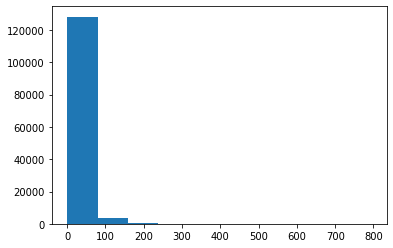

In [9]:
plt.hist([len(linha.split()) for linha in b2wCorpus["review_text"]])
plt.show()

In [10]:
vectorize_layer = TextVectorization(
                                        max_tokens=60106,
                                        standardize='lower_and_strip_punctuation',
                                        output_mode='int',
                                        pad_to_max_tokens=False,
                                        output_sequence_length=SEQUENCE_MAXLEN
                                        )

vectorize_layer.adapt(x_train)
vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)

60105


### Montando o modelo

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

##  <font color='blue'>Questão 4 </font>

Defina seu modelo.

Como analise de sentimentos pode ser visto como um problema de classificação, é interessante também registrar algumas métricas como acurácia `metrics=["acc"]` .

Seu modelo deve começar com a seguinte estrutura:
 - Camada de Input
 - Camada de Tokenização
 - Camada de Embedding
 
Já definimos as camadas seguintes da rede por você.
 
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.


In [11]:
dim = 128
#model = Sequential()
#model.add(Input(shape=(1, ), dtype=tf.string))
#model.add(vectorize_layer)
#model.add(Embedding(vocab_size + 2, dim, input_length=SEQUENCE_MAXLEN))

#model.add(Conv1D(filters=32, kernel_size=16, activation='relu', input_shape=(SEQUENCE_MAXLEN, dim), padding='same'))
#model.add(AveragePooling1D(pool_size=3, padding='valid'))

#model.add(Conv1D(filters=32, kernel_size=16, activation='relu', input_shape=(SEQUENCE_MAXLEN, dim), padding='same'))
#model.add(AveragePooling1D(pool_size=3, padding='valid'))

#model.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid'))
    


In [19]:
# define model
model = Sequential()
model.add(Input(shape=(1, ), dtype=tf.string))
model.add(vectorize_layer)
model.add(Embedding(vocab_size+2, 128, input_length=SEQUENCE_MAXLEN))
model.add(Conv1D(filters=24, kernel_size=16, activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='valid'))
model.add(Dropout(0.5))
#model.add(Conv1D(filters=14, kernel_size=16, activation='relu'))
#model.add(MaxPooling1D(pool_size=2, padding='valid'))
#model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 128)           7693696   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 24)            49176     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 24)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 24)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 17, 64)            1600      
_________________________________________________________________
dropout_3 (Dropout)          (None, 17, 64)           

### Treinando e avaliando seu modelo

##  <font color='blue'>Questão 5 </font>

Com seu modelo definido, treine e avalie sua performance no conjunto de testes, utilize camadas [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/) na sua rede.



In [20]:
#opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipvalue=5.0)
#opt= "adam"
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
   staircase=True)
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
#opt = tf.keras.optimizers.RMSprop(
#    learning_rate=0.3,
#    rho=0.9,
#    momentum=0.5,
#    epsilon=1e-07,
#    centered=False,
#    name="RMSprop"
#)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val)
)

Epoch 1/20
3310/3310 [==============================] - 21s 6ms/step - loss: 0.5737 - accuracy: 0.7272 - val_loss: 0.5550 - val_accuracy: 0.7302
Epoch 2/20
3310/3310 [==============================] - 21s 6ms/step - loss: 0.5633 - accuracy: 0.7274 - val_loss: 0.5535 - val_accuracy: 0.7302
Epoch 3/20
3310/3310 [==============================] - 21s 6ms/step - loss: 0.5597 - accuracy: 0.7274 - val_loss: 0.5497 - val_accuracy: 0.7302
Epoch 4/20
3310/3310 [==============================] - 22s 7ms/step - loss: 0.5554 - accuracy: 0.7276 - val_loss: 0.5434 - val_accuracy: 0.7302
Epoch 5/20
3310/3310 [==============================] - 20s 6ms/step - loss: 0.5448 - accuracy: 0.7335 - val_loss: 0.5265 - val_accuracy: 0.7427
Epoch 6/20
3310/3310 [==============================] - 20s 6ms/step - loss: 0.5282 - accuracy: 0.7495 - val_loss: 0.5023 - val_accuracy: 0.7760
Epoch 7/20
3310/3310 [==============================] - 22s 7ms/step - loss: 0.5138 - accuracy: 0.7655 - val_loss: 0.4905 - val_ac

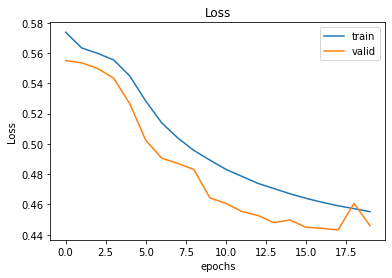

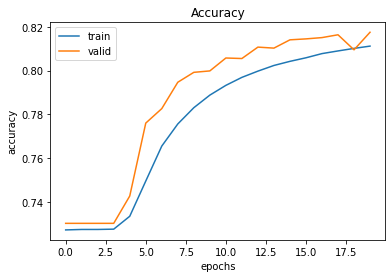

<Figure size 432x288 with 0 Axes>

In [21]:
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.show()
    plt.clf()

    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    plt.show()
    plt.clf()